In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from torchmetrics.classification import BinaryJaccardIndex
from utils import custom_replace
from data import batch_data_clean
import pooch

C:\Users\jfrancis\Anaconda3\envs\envAIGOV\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\jfrancis\Anaconda3\envs\envAIGOV\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
class treenet:
    def __init__(self, model_weights: dict = None, model_type = "multi_spectral"):

        if model_weights is None:
            # RGB
            if model_type == "rgb":
                model_weights = dict(url="doi:10.5281/zenodo.10149636/pytorch_mtloss_partshared_manual.pt",
                                     known_hash="md5:76fceb351a331d354cbe4d8e3da8a363")
                first_layer = 3
                self.num_bands_input = 3
            
            # 14 band, RGB + NIR + Sentinel 2 (10 bands)    
            if model_type == "multi_spectral":
                model_weights = dict(url="https://zenodo.org/records/10149637/files/pytorch_mtloss_partshared_manual_allbands.pt",
                                  known_hash="md5:450007e5233c08f595d549b873a9ff12")
                pooch.retrieve(url=model_weights['url'], known_hash= model_weights['known_hash'])
                first_layer = 14
                self.num_bands_input = 14
                
            if model_type != "rgb" and model_type != "multi_spectral":
                raise ValueError("model_type must be one of ['rgb','multi_spectral']")

        # ---- DOWNLOAD
        self.model_weights = pooch.retrieve(url=model_weights['url'], known_hash=model_weights['known_hash'])

        # ---- LOAD MODEL        
        def defineUNetModel_partiallyshared():
            def double_conv0(in_channels, out_channels):
                return nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 3, padding="same"),
                    nn.InstanceNorm2d(out_channels),
                    nn.LeakyReLU(inplace=True),
                    nn.Dropout(p=0.1),
                    nn.Conv2d(out_channels, out_channels, 3, padding="same"),
                    nn.InstanceNorm2d(out_channels),
                    nn.LeakyReLU(inplace=True)
                )  
            def double_conv(in_channels, out_channels):
                return nn.Sequential(
                    nn.Conv2d(in_channels, out_channels, 3, padding=1),
                    nn.LeakyReLU(inplace=True),
                    nn.Dropout(p=0.1),
                    nn.Conv2d(out_channels, out_channels, 3, padding=1),
                    nn.LeakyReLU(inplace=True)
                )
            
            class UNet(nn.Module):
                def __init__(self_unet):
                    super().__init__()
        
                    self_unet.dconv_down1 = double_conv0(first_layer, 32)
                    self_unet.dconv_down2 = double_conv(32, 64)
                    self_unet.dconv_down3 = double_conv(64, 128)
                    self_unet.dconv_down4 = nn.Sequential(
                        nn.Conv2d(128, 256, 3, padding=1),
                        nn.LeakyReLU(inplace=True),
                        nn.Dropout(p=0.2),
                        nn.Conv2d(256, 256, 3, padding=1),
                        nn.LeakyReLU(inplace=True))
        
                    self_unet.maxpool = nn.MaxPool2d(2)
                    self_unet.maxpool3 = nn.MaxPool2d(3)
                    
                    self_unet.upsample1a = nn.ConvTranspose2d(256, 128, 3, stride=3, padding=0)
                    self_unet.upsample1b = nn.ConvTranspose2d(256, 128, 3, stride=3, padding=0)
                    self_unet.upsample1c = nn.ConvTranspose2d(256, 128, 3, stride=3, padding=0)
                    
                    self_unet.upsample2a = nn.ConvTranspose2d(128, 64, 2, stride=2, padding=0)
                    self_unet.upsample2b = nn.ConvTranspose2d(128, 64, 2, stride=2, padding=0)
                    self_unet.upsample2c = nn.ConvTranspose2d(128, 64, 2, stride=2, padding=0)
                    
                    self_unet.upsample3a = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=0)
                    self_unet.upsample3b = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=0)
                    self_unet.upsample3c = nn.ConvTranspose2d(64, 32, 2, stride=2, padding=0)
                    
                    
                    self_unet.dconv_up3a = double_conv(128+128, 128)
                    self_unet.dconv_up3b = double_conv(128+128, 128)
                    self_unet.dconv_up3c = double_conv(128+128, 128)
                    
                    self_unet.dconv_up2a = double_conv(64 + 64, 64)
                    self_unet.dconv_up2b = double_conv(64 + 64, 64)
                    self_unet.dconv_up2c = double_conv(64 + 64, 64)
                    
                    self_unet.dconv_up1a = double_conv(32 + 32, 32)
                    self_unet.dconv_up1b = double_conv(32 + 32, 32)
                    self_unet.dconv_up1c = double_conv(32 + 32, 32)
        
                    self_unet.conv_lasta = nn.Conv2d(32, 1, 1)
                    self_unet.conv_lastb = nn.Conv2d(32, 1, 1)
                    self_unet.conv_lastc = nn.Conv2d(32, 1, 1)
                            
                    self_unet.linear = nn.MaxPool2d(2)
                    self_unet.sigmoid = nn.Sigmoid()
                def forward(self_unet, x):
                    conv1 = self_unet.dconv_down1(x)
                    x = self_unet.maxpool(conv1)
        
                    conv2 = self_unet.dconv_down2(x)
                    x = self_unet.maxpool(conv2)
        
                    conv3 = self_unet.dconv_down3(x)
                    x = self_unet.maxpool3(conv3)
        
                    encoder_end = self_unet.dconv_down4(x)
        
                    
                    # Tree Height
                    x1 = self_unet.upsample1a(encoder_end)
                    x1 = torch.cat([x1, conv3], dim=1)
                    x1 = self_unet.dconv_up3a(x1)
        
                    x1 = self_unet.upsample2a(x1)
                    x1 = torch.cat([x1, conv2], dim=1)
                    x1 = self_unet.dconv_up2a(x1)
        
                    x1 = self_unet.upsample3a(x1)
                    x1 = torch.cat([x1, conv1], dim=1)
                    x1 = self_unet.dconv_up1a(x1)
                    out_tree_height = self_unet.conv_lasta(x1) # looks like i don't need any additional activation here for linear
        
                    # Tree Mask
                    x2 = self_unet.upsample1b(encoder_end)
                    x2 = torch.cat([x2, conv3], dim=1)
                    x2 = self_unet.dconv_up3b(x2)
        
                    x2 = self_unet.upsample2b(x2)
                    x2 = torch.cat([x2, conv2], dim=1)
                    x2 = self_unet.dconv_up2b(x2)
        
                    x2 = self_unet.upsample3b(x2)
                    x2 = torch.cat([x2, conv1], dim=1)
                    x2 = self_unet.dconv_up1b(x2)
                    out_tree_mask = self_unet.sigmoid(self_unet.conv_lastb(x2))            
             
                    
                    return [out_tree_height, out_tree_mask]
            model=UNet()
            return model
        
        treenet = defineUNetModel_partiallyshared().to(device)   
         
        # Load in the model weights
        treenet.load_state_dict(torch.load(self.model_weights, map_location=torch.device('cpu')))
        
        #initialise the model
        self.model = treenet


    def show_output(self, obs, preds_m, preds_h):

        # Original Image
        ax = plt.subplot(1,3, 1)
        plt.imshow(np.transpose(obs.squeeze()[0:3], axes=[1,2,0])/255)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
        
        # Predicted Tree Mask
        ax = plt.subplot(1,3, 2)
        plt.imshow(preds_m.squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
        
        # Predicted Tree Height
        ax = plt.subplot(1,3, 3)
        plt.imshow(preds_h.squeeze())
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.set_aspect('equal')
            
        
        plt.show()

    def predict_batch(self, images: np.ndarray, batch_size: int):
        # want shape (N, 14,240,240) or (N, 3,240,240)
        if (len(images.shape)!=4) or (images.shape[1]!=14 and images.shape[1]!=3) or (images.shape[2]!=240 or images.shape[3]!=240):
            raise ValueError("Images must be of shape (N, 14,240,240) or (N, 3,240,240)")
            
        if len(image)<=1:
            raise ValueError("You must have multiple images to use predict_batch. If you only have one image try the predict function.")
            
        if batch_size<=1:
            raise ValueError("batch_size must be greater than 1")
            
        if images.shape[1] != self.num_bands_input:
            raise ValueError("Ensure the model you have selected and the images you input have matching numbers of light bands.") 

        device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        my_dataset = batch_data_clean(image_arrays=images)
        my_dataloader = DataLoader(my_dataset, batch_size=batch_size,shuffle=False)
        
        
        all_tree_heights = []
        all_tree_masks = []
        with torch.inference_mode():
            for i_batch, sample_batched in enumerate(my_dataloader):
                image_batch= sample_batched
                
                image_batch= image_batch.to(device)
                #image_batch = Variable(image_batch.float().cuda())
                image_batch = Variable(image_batch.float())

                # Forward pass
                pred_tree_heights, pred_tree_masks = self.model(image_batch)
        
                # mask predicted tree height with the tree mask
                pred_tree_masks = custom_replace(pred_tree_masks, .4) # .4+ probability= tree
                pred_tree_heights[pred_tree_heights  < 0 ] = 0 # no negative tree heights
                pred_tree_heights = torch.squeeze(pred_tree_heights)*torch.squeeze(pred_tree_masks) #0s get rid of non tree pixels
                all_tree_heights.extend(pred_tree_heights)
                all_tree_masks.extend(torch.squeeze(pred_tree_masks))
        
        # For now just visualize the first image
        self.show_output(images[0],all_tree_masks[0], all_tree_heights[0])

        return all_tree_masks, all_tree_heights

    def predict(self, np_image: np.ndarray) -> np.ndarray:
        # want shape (14,240,240) or (3,240,240)
        if image.shape != (14, 240, 240) and image.shape != (3, 240, 240):
            raise ValueError("Image shape must be of (14,240,240) or (3,240,240). If you have multiple images, use predict_batch.")       
        
        if len(image) != self.num_bands_input:
            raise ValueError("Ensure the model you have selected and the image you input have matching numbers of light bands.") 
        
        # copy for plotting... better way to do this?
        og_image = np_image.copy()
        
        # want shape (1,14,240,240)
        np_image = np.expand_dims(np_image[:self.num_bands_input], axis=0)
        np_image[np_image  < .0000001] = 0 # Ensure no very small values (might have been an artifact of the original data)
        
        # normalize values of the input data to 0,1
        np_image = np_image/np_image.max(axis=(1),keepdims=True)
        
        np_image = torch.from_numpy(np_image)
        np_image = np_image.to(device)
        np_image = Variable(np_image.float())
        #np_image = Variable(np_image.float().cuda())
        
        with torch.inference_mode():
            pred_tree_height, pred_tree_mask = self.model(np_image)
            pred_tree_mask = custom_replace(pred_tree_mask, .4) # .4+ probability= tree
            pred_tree_height[pred_tree_height  < 0 ] = 0 # no negative tree heights
            pred_tree_height = torch.squeeze(pred_tree_height)*torch.squeeze(pred_tree_mask) #0s get rid of non tree pixels

        self.show_output(og_image,pred_tree_mask, pred_tree_height)

        return pred_tree_mask, pred_tree_height


if __name__ == "__main__":
    pass

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = treenet(model_type = "rgb")

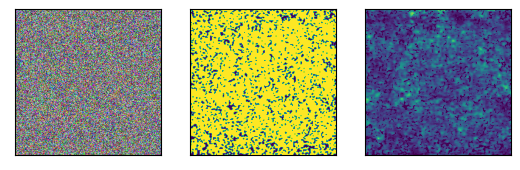

In [4]:
# test numpy array
# load model
device = "cuda" if torch.cuda.is_available() else "cpu"
model = treenet(model_type = "multi_spectral")

## create RGB image
image = np.random.randint(255, size=(14, 240, 240), dtype=np.uint8)

##predict
y = model.predict(np_image=image)

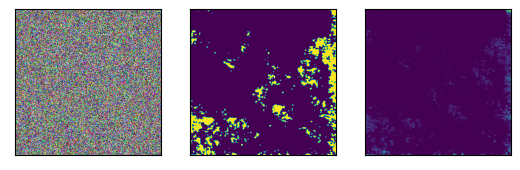

2 25 25


In [5]:
# test batch
##predict
#image_batch = 
model = treenet(model_type = "rgb")
images = np.random.randint(255, size=(25, 3, 240, 240), dtype=np.uint8)
y = model.predict_batch(images, batch_size=16)
print(len(y),len(y[0]),len(y[1]))

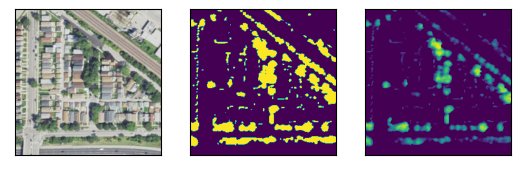

In [6]:
a= np.load("../example_data/P_1_X0_1_X1_240_Y0_1_Y1_240_113.npy",allow_pickle=True)
model = treenet(model_type = "multi_spectral")
y = model.predict(np_image=a)

In [7]:
%run -i "../test/test.py"

ModuleNotFoundError: No module named 'canopy_model'